## Review Model Outputs

### Includes:
- methods to visualise model outputs
- methods to compare model outputs

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sklearn
import shapely.wkt
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
import hdbscan # new clustering algorithm
import mplleaflet
from scipy.spatial.distance import pdist, squareform, euclidean, directed_hausdorff
from haversine import haversine


%matplotlib inline

In [2]:
gdf = gpd.read_file("../app_route_data/trajets_mtl_trajet_2017.shp", encoding='utf-8') # utf-8 needed to read french letters
mtl_region = gpd.read_file("../shapes/mtl_all_regions.json")
mtl_dissem = gpd.read_file("../shapes/mtl_dissem.geojson")
mtl_greater = gpd.read_file("../shapes/greater_montreal.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]

In [3]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)
mtl_greater = mtl_greater.dissolve(by="CMANAME")

In [4]:
# outlier removal
gdf = gdf.loc[gdf.distance_m >= 50]
gdf = gdf.loc[gdf.seconds >= 60]
gdf = gdf.loc[gdf.distance_m <= 100000]
gdf = gdf.loc[gdf.seconds <= 10800]
gdf = gdf.dropna(subset=['mode'])
gdf = gdf.reset_index(drop=True)

In [5]:
# turn the data back into datetime
gdf['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
gdf['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [6]:
gdf['log_dur'] = np.log(gdf.seconds+1)
gdf['log_dist'] = np.log(gdf.distance_m+1)

In [7]:
new_classifications = {"1":["shops","leisure","cafe","returning_home"],"2":["education"],\
                       "3":["health"],"4":["pick_up_a_person"],"5":["work"]}

In [8]:
def new_pur_labels(row, purpose_label_dict=new_classifications):
    for key, val in purpose_label_dict.items():
        if row.purpose in val:
            return key

    return None

In [9]:
gdf['purpose_labels'] = gdf.apply(new_pur_labels, axis=1)
gdf.purpose_labels.value_counts()

1    47464
5    18950
2     2769
4     1574
3     1044
Name: purpose_labels, dtype: int64

In [10]:
gdf = gdf.dropna(subset=["purpose_labels"])

## Evaluate

In [87]:
print(rf_scores['purp_gdf'].mean(), cv_scores_svc['purp_gdf'].mean(), cv_scores_nn['purp_gdf'].mean())

0.5888038659999999 0.47588098755011604 0.427327154


In [88]:
print(rf_scores['purp_gdf'].max()-rf_scores['purp_gdf'].min(),\
      cv_scores_svc['purp_gdf'].max()-cv_scores_svc['purp_gdf'].min(),
      cv_scores_nn['purp_gdf'].max()-cv_scores_nn['purp_gdf'].min())

0.00972613 0.47588098755011604 0.014967260000000038


In [1103]:
normal_means = 67,48,69
oversampled_means = cv_scores_mcrf_oversampled['purp_gdf'].mean(), cv_scores_svc_oversampled['purp_gdf'].mean(),  cv_scores_nn_oversampled['purp_gdf'].mean()
undersampled_means = cv_scores_mcrf_undersampled['purp_gdf'].mean(),  cv_scores_nn_undersampled['purp_gdf'].mean(), cv_scores_svc_undersampled['purp_gdf'].mean() 



all_means = pd.DataFrame([rf_means, svc_means,nn_means], columns=['Unchanged','Over-sampled','Under-sampled'])
all_means = all_means*100
# all_means.columns = ["RF","SVM","MLP"]

In [1104]:
all_means['unchanged'] = normal_means

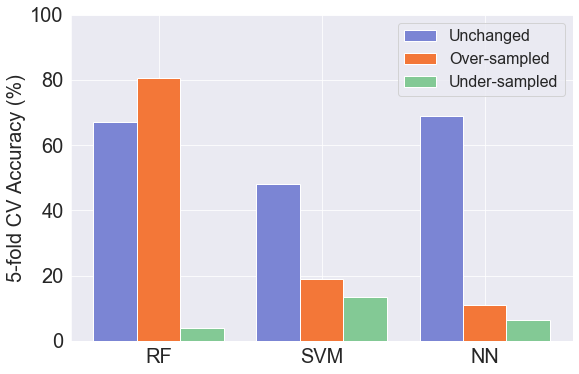

In [1106]:
x = 0

y = all_means['unchanged'].values
z = all_means['Over-sampled'].values
k = all_means['Under-sampled'].values
ax = plt.subplots(1, figsize=(9,6))
for x, y, z, k in zip([0,0.75,1.5], all_means['unchanged'].values, all_means['Over-sampled'].values, all_means['Under-sampled'].values):
    plt.bar(x-0.2, y, width=0.2, color="#7b85d4", align='center')
    plt.bar(x, z, width=0.2, color='#f37738', align='center')
    plt.bar(x+0.2, k, width=0.2, color='#83c995', align='center')
plt.legend(["Unchanged","Over-sampled","Under-sampled"], fontsize=16)
plt.ylim(0,100)
plt.xticks([0,0.75,1.5],["RF","SVM","NN"],size=20)
plt.yticks(size=20)
# plt.xlabel("Model", size=20)
plt.ylabel("5-fold CV Accuracy (%)", size=20)
# plt.savefig("figures/undervsover.png",bbox_inches='tight')

In [1038]:
joined_mode_data = gpd.read_file("analysis_results/joined_model_data.shp")

In [1039]:
joined_mode_data.purpose.unique()

array(['work', 'shops', 'returning_home', 'pick_up_a_person', 'education',
       'leisure', 'health', 'cafe'], dtype=object)

In [1040]:
joined_mode_data.purpose.value_counts()

returning_home      8879
work                6247
leisure             2998
shops               2758
cafe                1026
education            955
pick_up_a_person     510
health               322
Name: purpose, dtype: int64

In [1041]:
gdf.purpose.value_counts()

returning_home      26819
work                18950
leisure              9167
shops                8363
cafe                 3115
education            2769
pick_up_a_person     1574
health               1044
Name: purpose, dtype: int64

In [1042]:
factors_purpose = {'pick_up_a_person':1, 'work':2, 'shops':3, 'returning_home':4, 'health':5,
       'leisure':6, 'education':7, 'cafe':8}

In [1043]:
factors_purpose

{'pick_up_a_person': 1,
 'work': 2,
 'shops': 3,
 'returning_home': 4,
 'health': 5,
 'leisure': 6,
 'education': 7,
 'cafe': 8}

In [1044]:
joined_mode_data['purpose_la'] = joined_mode_data.purpose.apply(lambda row: factors_purpose[row])

In [1045]:
joined_mode_data['purpose_la'].value_counts()

4    8879
2    6247
6    2998
3    2758
8    1026
7     955
1     510
5     322
Name: purpose_la, dtype: int64

In [1046]:
joined_mode_data.purpose_la = joined_mode_data.purpose_la.astype(float)

In [1047]:
def check_scores(row):
    svc_correct = int(row['purpose_la']) == int(row['svcall'])
    rf_correct = int(row['rf' + str(int(row['purpose_la']))]) == 1
    nn_correct = int(row['nn' + str(int(row['purpose_la']))]) == 1
    return rf_correct, svc_correct, nn_correct

In [1048]:
check_scores(joined_mode_data.loc[0])

(False, True, True)

In [1116]:
joined_mode_data["which_correct"] = joined_mode_data.apply(check_scores, axis=1)

In [1117]:
each_correct = joined_mode_data["which_correct"].apply(pd.Series)
each_correct.columns = ["svc_corr","rf_corr","nn_corr"]
joined_mode_data = pd.concat([joined_mode_data, each_correct], axis=1)

In [1132]:
all_true = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr == True)]
no_true = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr != True)]
any_true = joined_mode_data.loc[(joined_mode_data.svc_corr == True)|(joined_mode_data.rf_corr == True)|(joined_mode_data.nn_corr == True)]
only_svc = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr != True)]
only_rf = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr != True)]
only_nn = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr == True)]
all_but_svc = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr == True)]
all_but_rf = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr == True)]
all_but_nn = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr != True)]



In [1011]:
true_matrix = [len(only_svc), len(only_rf), len(only_nn), len(all_but_svc),len(all_but_rf),len(all_but_nn)]



In [1012]:
true_matrix

[605, 2179, 421, 1665, 1076, 575]

In [1013]:
joined_mode_data.groupby(["svc_corr","rf_corr","nn_corr"]).count()['id_trip'].reset_index()

,svc_corr,rf_corr,nn_corr,id_trip
0,False,False,False,10317
1,False,False,True,421
2,False,True,False,2179
3,False,True,True,1665
4,True,False,False,605
5,True,False,True,1076
6,True,True,False,575
7,True,True,True,6857


In [688]:
true_vals = np.matrix([[605,575,1076],[575,2179,1665],[1076,1665, 421]])
true_vals = np.matrix([[605,575,1076],[575,2179,1665],[1076,1665, 421]])

In [689]:
true_vals

matrix([[ 605,  575, 1076],
        [ 575, 2179, 1665],
        [1076, 1665,  421]])

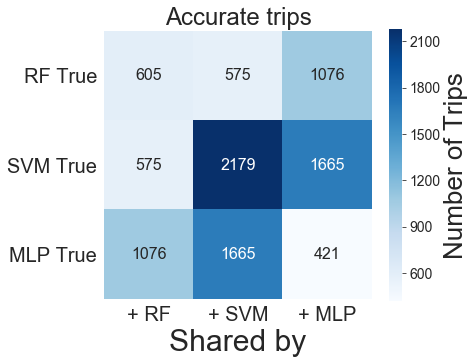

In [1176]:
fig, ax=plt.subplots(1, figsize=(6,5))
sns.heatmap(true_vals, cmap='Blues', annot=True, fmt='.0f', annot_kws={'fontsize':16}, square=True, ax=ax, cbar_kws={'label':'Number of Trips'})
ax.set_yticklabels(['RF True','SVM True','MLP True'],size=20, rotation=0)
ax.set_xticklabels(['+ RF','+ SVM','+ MLP'],size=20, rotation=0)
ax.set_xlabel("Shared by", size=30)
plt.title("Accurate trips",size=24)
ax.figure.axes[-1].yaxis.label.set_size(26)
ax.figure.axes[-1].set_yticklabels([round(val, 2) for val in np.arange(300,2101, 300)],fontsize=14);
# plt.savefig("figures/accuracy_matirx.png",bbox_inches='tight')

In [91]:
all_true.purpose.value_counts()

returning_home    4325
work              2532
Name: purpose, dtype: int64

In [92]:
no_true.purpose.value_counts()

leisure             2789
shops               2547
work                1120
returning_home      1097
cafe                1022
education            911
pick_up_a_person     509
health               322
Name: purpose, dtype: int64

In [93]:
only_nn.purpose.value_counts()

work              248
returning_home     92
leisure            45
shops              34
education           2
Name: purpose, dtype: int64

In [94]:
only_svc.purpose.value_counts(), only_rf.purpose.value_counts(), only_nn.purpose.value_counts()

(returning_home    1274
 work               905
 Name: purpose, dtype: int64, returning_home      157
 shops               143
 work                137
 leisure             126
 education            37
 cafe                  4
 pick_up_a_person      1
 Name: purpose, dtype: int64, work              248
 returning_home     92
 leisure            45
 shops              34
 education           2
 Name: purpose, dtype: int64)

In [102]:
joined_mode_data["svcall"].value_counts()

4.0    14655
2.0     9040
Name: svcall, dtype: int64

In [110]:
13375 / sum(joined_mode_data[["rf1","rf2","rf3","rf4","rf5","rf6","rf7","rf8"]].sum(axis=1).value_counts())

0.6086094112682

In [104]:
joined_mode_data[["rf1","rf2","rf3","rf4","rf5","rf6","rf7","rf8"]].sum(axis=1).value_counts()

1.0    13375
0.0    10207
2.0      113
dtype: int64

In [96]:
joined_mode_data[["nn1","nn2","nn3","nn4","nn5","nn6","nn7","nn8"]].sum(axis=1).value_counts()

1.0    14421
0.0     9271
2.0        3
dtype: int64

In [1052]:
max_ind = []
for row in joined_mode_data[["nn1","nn2","nn3","nn4","nn5","nn6","nn7","nn8"]].iterrows():
    max_ind.append(np.where(row[1].values == np.amax(row[1].values))[0]+1)
joined_mode_data['nn_pred'] = [float(val[0]) if len(val) == 1 else None for val in max_ind]

In [1036]:
max_ind = []
for row in joined_mode_data[["rf1","rf2","rf3","rf4","rf5","rf6","rf7","rf8"]].iterrows():
    max_ind.append(np.where(row[1].values == np.amax(row[1].values))[0]+1)
joined_mode_data['rf_pred'] = [float(val[0]) if len(val) == 1 else None for val in max_ind]

In [424]:
from sklearn.metrics import classification_report
print('Results on the test set: RF:')
print(classification_report(joined_mode_data.dropna(subset=['rf_pred']).purpose_la, joined_mode_data.dropna(subset=['rf_pred']).rf_pred))

print('Results on the test set: SVC:')
print(classification_report(joined_mode_data.purpose_la, joined_mode_data.svcall))
print('Results on the test set: NN:')
print(classification_report(joined_mode_data.dropna(subset=['nn_pred']).purpose_la, joined_mode_data.dropna(subset=['nn_pred']).nn_pred))


Results on the test set: RF:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       245
         2.0       0.76      0.86      0.80      4271
         3.0       0.40      0.16      0.23      1045
         4.0       0.66      0.91      0.77      5448
         5.0       0.00      0.00      0.00       159
         6.0       0.34      0.12      0.18      1288
         7.0       0.36      0.06      0.10       515
         8.0       0.20      0.01      0.02       404

    accuracy                           0.67     13375
   macro avg       0.34      0.27      0.26     13375
weighted avg       0.60      0.67      0.61     13375

Results on the test set: SVC:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       510
         2.0       0.43      0.62      0.50      6247
         3.0       0.00      0.00      0.00      2758
         4.0       0.51      0.84      0.63      8879
         5.0       

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [448]:
rf_report = pd.DataFrame(classification_report(joined_mode_data.dropna(subset=['rf_pred']).purpose_la, joined_mode_data.dropna(subset=['rf_pred']).rf_pred, output_dict=True)).T.iloc[:8].drop('support', axis=1)
svm_report = pd.DataFrame(classification_report(joined_mode_data.purpose_la, joined_mode_data.svcall,output_dict=True)).T.iloc[:8].drop('support', axis=1)
nn_report = pd.DataFrame(classification_report(joined_mode_data.dropna(subset=['nn_pred']).purpose_la, joined_mode_data.dropna(subset=['nn_pred']).nn_pred, output_dict=True)).T.iloc[:8].drop('support', axis=1)




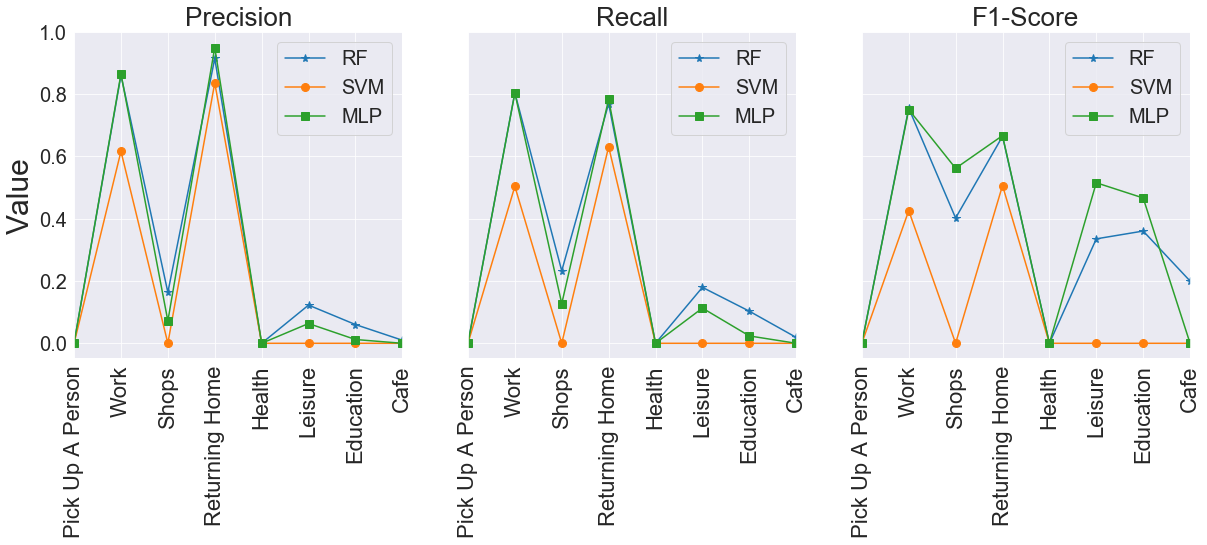

In [493]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(1,3, figsize=(20,6), sharex=True, sharey=True)
rf_report.recall.plot(marker='*', ax=axes[0], markersize=8)
svm_report.recall.plot(marker='o', ax=axes[0], markersize=8)
nn_report.recall.plot(marker='s', ax=axes[0], markersize=8)
rf_report.precision.plot(marker='*', ax=axes[2], markersize=8)
svm_report.precision.plot(marker='o', ax=axes[2], markersize=8)
nn_report.precision.plot(marker='s', ax=axes[2], markersize=8)
rf_report['f1-score'].plot(marker='*', ax=axes[1], markersize=8)
svm_report['f1-score'].plot(marker='o', ax=axes[1], markersize=8)
nn_report['f1-score'].plot(marker='s', ax=axes[1], markersize=8)
for ax, title_label in zip(axes, ["Precision","Recall","F1-Score"]):
    ax.legend(["RF","SVM","MLP"], fontsize=20)
    ax.set_title(title_label, size=26)
    ax.set_xticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=22, rotation=90)
    ax.set_yticks(np.arange(0,1.1,0.2))
#     ax.set_ylim(0,1)

axes[0].set_yticklabels([round(val, 1) for val in np.arange(0,1.1,0.2)],size=20);
axes[0].set_ylabel("Value",size=30)
# plt.savefig("figures/precrecall_f1_line.png", bbox_inches='tight')



In [133]:
rf_matrix np.sum(rf_matrix, axis=1)

array([ 510, 6247, 2758, 8879,  322, 2998,  955, 1026])

In [156]:
joined_mode_data.purpose_la.value_counts()

4.0    8879
2.0    6247
6.0    2998
3.0    2758
8.0    1026
7.0     955
1.0     510
5.0     322
Name: purpose_la, dtype: int64

In [355]:
joined_mode_data.svcall.value_counts()

4.0    14655
2.0     9040
Name: svcall, dtype: int64

In [354]:
joined_mode_data.purpose_la.value_counts()

4.0    8879
2.0    6247
6.0    2998
3.0    2758
8.0    1026
7.0     955
1.0     510
5.0     322
Name: purpose_la, dtype: int64

In [350]:
rf_matrix = confusion_matrix(joined_mode_data.dropna(subset=['rf_pred']).purpose_la, joined_mode_data.dropna(subset=['rf_pred']).rf_pred)
svm_matrix = confusion_matrix(joined_mode_data.purpose_la, joined_mode_data.svcall)
nn_matrix = confusion_matrix(joined_mode_data.dropna(subset=['nn_pred']).purpose_la, joined_mode_data.dropna(subset=['nn_pred']).nn_pred)
                                                     



In [240]:
purpose_classes = ['pick_up_a_person', 'work', 'shops', 'returning_home', 'health', 'leisure', 'education', 'cafe']

In [241]:
purpose_classes

['pick_up_a_person',
 'work',
 'shops',
 'returning_home',
 'health',
 'leisure',
 'education',
 'cafe']

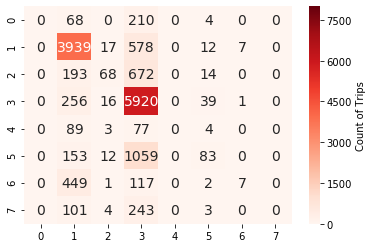

In [385]:
sns.heatmap(nn_matrix, cmap='Reds', annot=True, fmt='.0f',annot_kws={'fontsize':14}, cbar=True, vmin=0,vmax=8000, cbar_kws ={'label':'Count of Trips'})


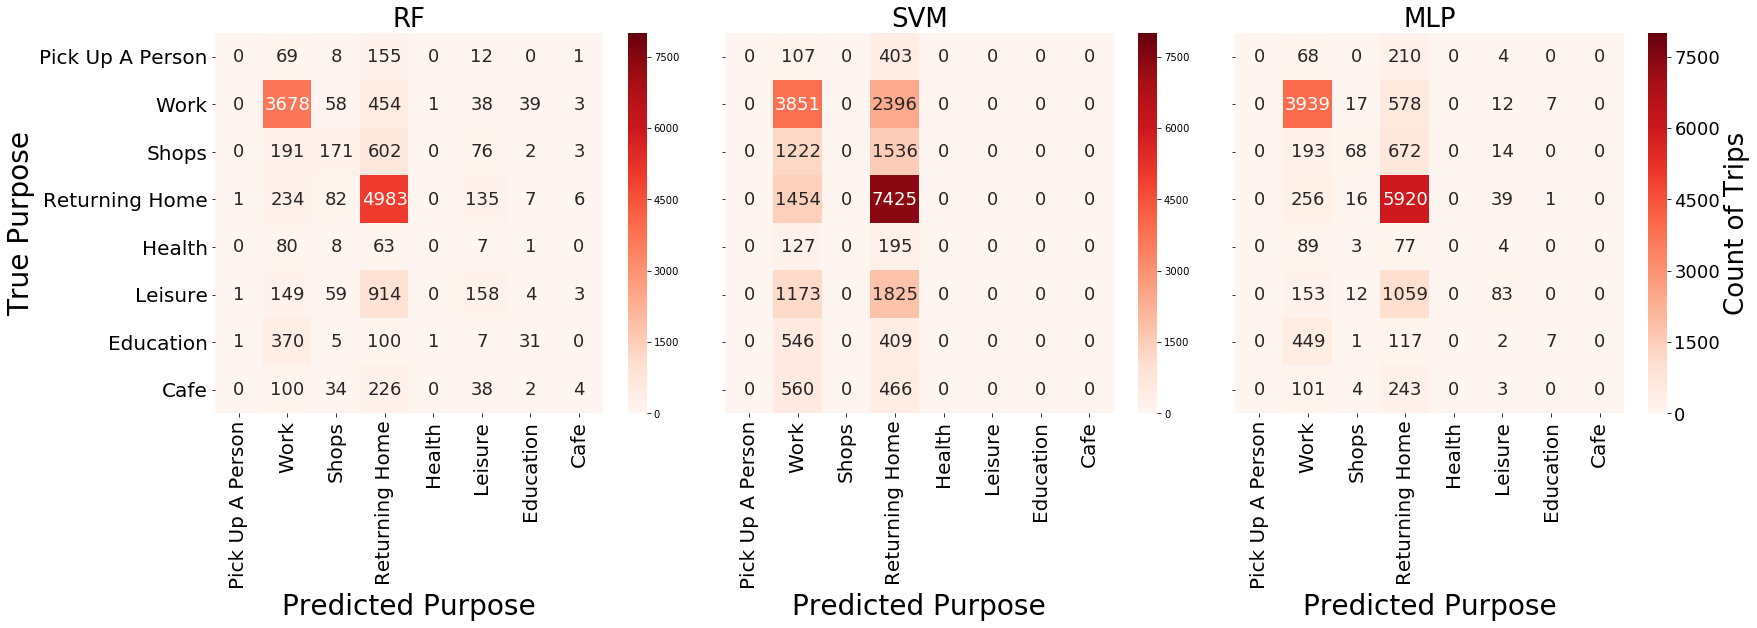

In [392]:
fig, axes = plt.subplots(1, 3, figsize=(27,7), sharey=True)
ax.set_title("", size=22)
sns.heatmap(rf_matrix, cmap='Reds', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[0], cbar=True, vmin=0,vmax=8000)
sns.heatmap(svm_matrix, cmap='Reds', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[1], cbar=True, vmin=0,vmax=8000)
sns.heatmap(nn_matrix, cmap='Reds', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[2], cbar=True, vmin=0,vmax=8000, cbar_kws ={'label':'Count of Trips'})
for ax, title_lab in zip(axes, ["RF", "SVM", "MLP"]):
    if not title_lab == "MLP":
        ax.invert_yaxis()
    ax.set_yticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=20, rotation=0);
    ax.set_xticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=20, rotation=90);
    ax.set_xlabel("Predicted Purpose", size=28)
    ax.set_title(title_lab, size=26)
    
axes[0].figure.axes[-1].yaxis.label.set_size(26)
axes[0].set_ylabel("True Purpose", size=28)
plt.subplots_adjust(wspace=.05)
# axes[0].figure.axes[2].set_yticklabels([round(val, 2) for val in np.arange(0,1.1,0.2)],fontsize=20);
axes[0].figure.axes[-1].set_yticklabels([round(val, 2) for val in np.arange(0,8000,1500)],fontsize=18);
# plt.savefig("figures/compare_model_labels.png", bbox_inches='tight')


In [418]:
joined_mode_data.purpose_la.value_counts()

4.0    8879
2.0    6247
6.0    2998
3.0    2758
8.0    1026
7.0     955
1.0     510
5.0     322
Name: purpose_la, dtype: int64

In [419]:
joined_mode_data.dropna(subset=['rf_pred']).purpose_la.value_counts()
# joined_mode_data.dropna(subset=['nn_pred']).purpose_la.value_counts()

4.0    5448
2.0    4271
6.0    1288
3.0    1045
7.0     515
8.0     404
1.0     245
5.0     159
Name: purpose_la, dtype: int64

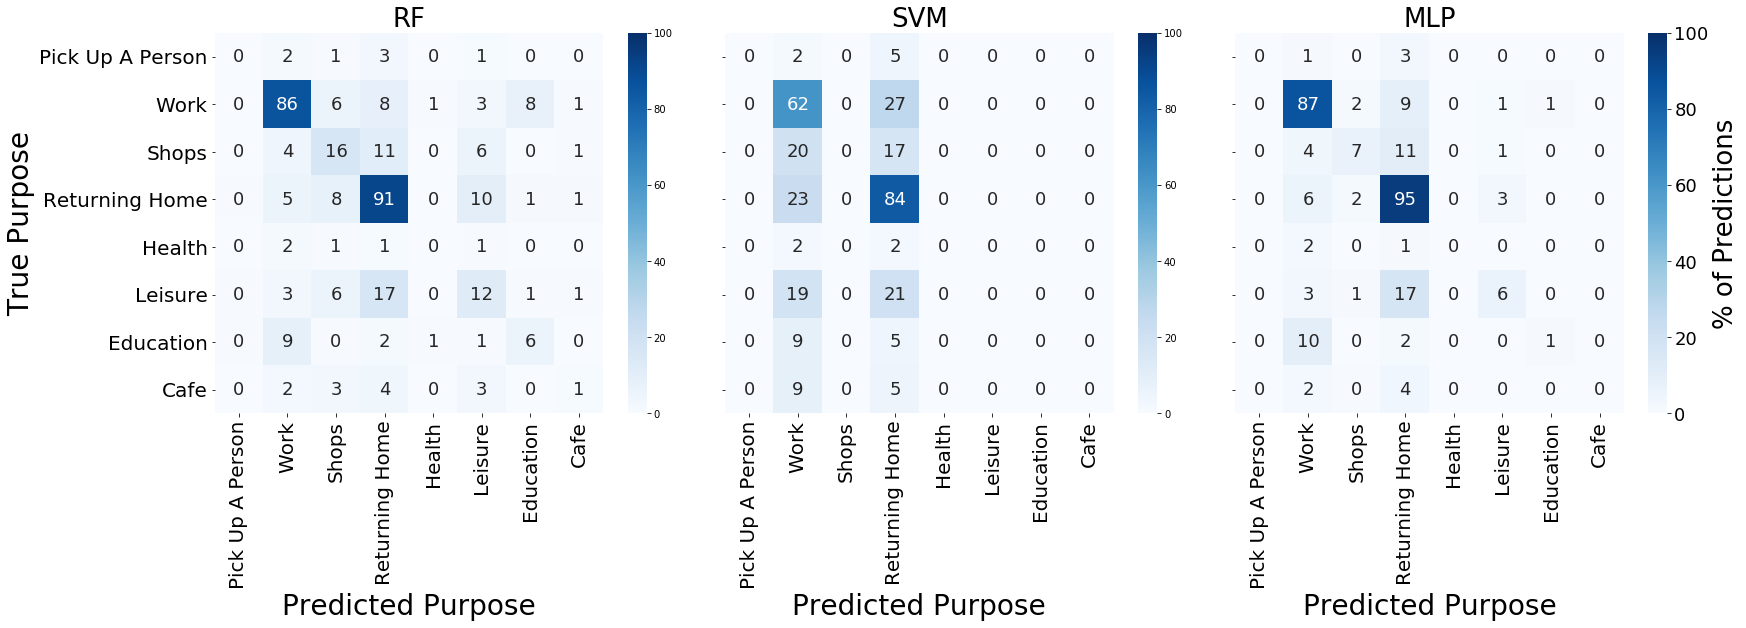

In [423]:
fig, axes = plt.subplots(1, 3, figsize=(27,7), sharey=True)
ax.set_title("", size=22)
sns.heatmap((rf_matrix / np.array([245, 4271,1045,5448,159,1288,515,404]).reshape(1,-1))*100, cmap='Blues', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[0], cbar=True, vmin=0,vmax=100)
sns.heatmap((svm_matrix / np.array([510, 6247,2758,8879,322,2998,955,1026]).reshape(1,-1))*100, cmap='Blues', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[1], cbar=True, vmin=0,vmax=100)
sns.heatmap((nn_matrix / np.array([282, 4553,947,6232,173,1307,576,351]).reshape(1,-1))*100, cmap='Blues', annot=True, fmt='.0f',annot_kws={'fontsize':18}, ax=axes[2], cbar=True, vmin=0,vmax=100, cbar_kws ={'label':'% of Predictions'})
for ax, title_lab in zip(axes, ["RF", "SVM", "MLP"]):
    if not title_lab == "MLP":
        ax.invert_yaxis()
    ax.set_yticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=20, rotation=0);
    ax.set_xticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=20, rotation=90);
    ax.set_xlabel("Predicted Purpose", size=28)
    ax.set_title(title_lab, size=26)
    
axes[0].figure.axes[-1].yaxis.label.set_size(26)
axes[0].set_ylabel("True Purpose", size=28)
plt.subplots_adjust(wspace=.05)
# axes[0].figure.axes[2].set_yticklabels([round(val, 2) for val in np.arange(0,1.1,0.2)],fontsize=20);
axes[0].figure.axes[-1].set_yticklabels([round(val, 2) for val in np.arange(0,110,20)],fontsize=18);
# plt.savefig("figures/compare_model_labels_per_accurate.png", bbox_inches='tight')

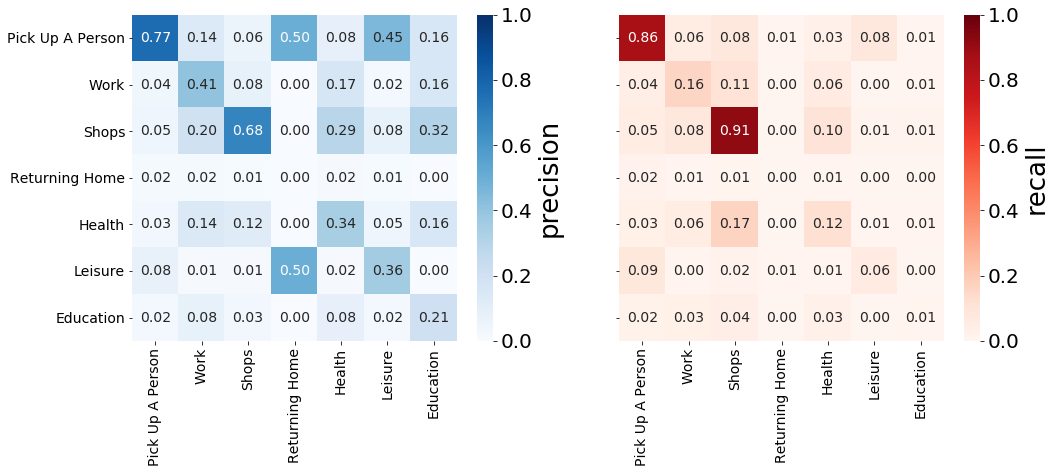

In [265]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16,6), sharey=True)
sns.heatmap(rf_matrix /np.sum(rf_matrix, axis=0),vmin=0, vmax=1, fmt='.2f', annot=True, cmap="Blues", annot_kws={'fontsize':14}, cbar_kws ={'label':'precision'}, ax=ax)
sns.heatmap(rf_matrix /np.sum(rf_matrix, axis=1),vmin=0, vmax=1, fmt='.2f', annot=True, cmap="Reds", annot_kws={'fontsize':14}, cbar_kws={'label':'recall'}, ax=ax2)
ax.invert_yaxis()
ax.figure.axes[2].yaxis.label.set_size(26)
ax.figure.axes[2].set_yticklabels([round(val, 2) for val in np.arange(0,1.1,0.2)],fontsize=20)
ax2.figure.axes[-1].yaxis.label.set_size(26)
ax2.figure.axes[-1].set_yticklabels([round(val, 2) for val in np.arange(0,1.1,0.2)],fontsize=20)
plt.subplots_adjust(wspace=.2)
ax.set_title("", size=22)
ax.set_yticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=14, rotation=0);
ax.set_xticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=14, rotation=90);
ax.set_title("", size=22)
ax2.set_xticklabels([pur.replace("_"," ").title() for pur in purpose_classes], size=14, rotation=90);
ax.set_title("", size=20);
ax2.set_title("", size=20);


## Map errors

In [764]:
# convert the point columns back into a Point class
gdf['start_wgs'] = gdf['start_wgs'].apply(shapely.wkt.loads)
gdf['start_can'] = gdf['start_can'].apply(shapely.wkt.loads)
gdf['end_wgs'] = gdf['end_wgs'].apply(shapely.wkt.loads)
gdf['end_can'] = gdf['end_can'].apply(shapely.wkt.loads)

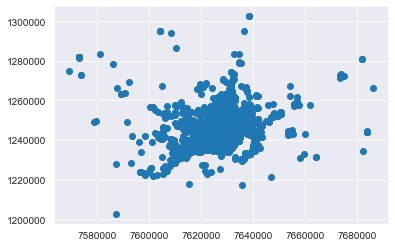

In [772]:
plt.scatter(all_true.startx, all_true.starty)

(1220000, 1300000)

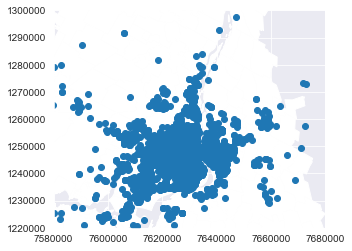

In [790]:
fig, ax = plt.subplots(1)
mtl_region.plot(ax=ax, color='white')
ax.scatter(no_true.endx, no_true.endy)
plt.xlim(7580000, 7680000)
plt.ylim(1220000, 1300000)

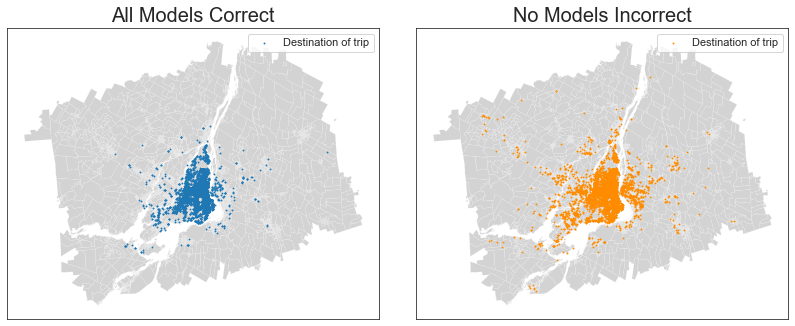

In [837]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(14,7))
mtl_dissem.plot(ax=ax, color='lightgrey', linewidth=.1)
mtl_dissem.plot(ax=ax2, color='lightgrey', linewidth=.1)
ax.scatter(all_true.endx, all_true.endy, s=.75)
ax2.scatter(no_true.endx, no_true.endy, s=.75, color='darkorange')
for ax, df_name in zip([ax,ax2], ["All Models Correct","No Models Incorrect"]):
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.set_title(df_name, size=20)
    ax.legend(["Destination of trip"], fontsize=11)
#     lgnd.legendHandles[0]._legmarker.set_markersize(6)
plt.subplots_adjust(wspace=.1)

# plt.savefig("figures/overall_error_correct_scatter.png".format(df_name.replace(" ","")), bbox_inches='tight')


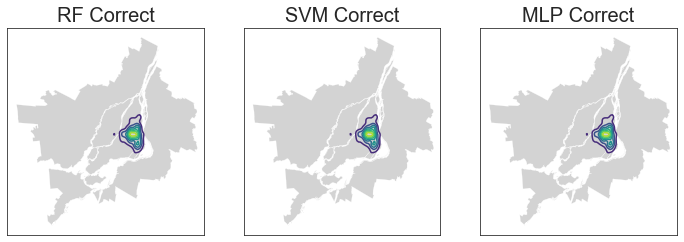

In [816]:
sns.set_style('white')
fig, axes = plt.subplots(1,3, figsize=(12,7))
for df, df_name, ax in zip([only_rf, only_svc,only_nn],["RF Correct","SVM Correct","MLP Correct"], axes):
    mtl_greater.plot(ax=ax, color='lightgrey', linewidth=.2)
    sns.kdeplot(only_nn.endx, only_nn.endy, s=.5, cmap='viridis', ax=ax)
    # plt.xlim(7580000, 7680000)
    # plt.ylim(1220000, 1300000)
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    ax.set_xlabel("");
    ax.set_ylabel("");
    ax.set_title(df_name, size=20)
# plt.savefig("figures/overall_error_kde.png".format(df_name.replace(" ","")), bbox_inches='tight')


In [ ]:
for df, df_name in zip([only_rf, only_svc,only_nn],["RF Correct","SVM Correct","MLP Correct"]):
    fig, ax = plt.subplots(1, figsize=(12,7))
    mtl_greater.plot(ax=ax, color='lightgrey', linewidth=.2)
    sns.kdeplot(only_nn.endx, only_nn.endy, s=.5, cmap='viridis')
    # plt.xlim(7580000, 7680000)
    # plt.ylim(1220000, 1300000)
    plt.xticks([]);
    plt.yticks([]);
    plt.xlabel("");
    plt.ylabel("");
    plt.title(df_name, size=20)
    plt.savefig("figures/{0}_kde.png".format(df_name.replace(" ","")), bbox_inches='tight')
    plt.show()
    plt.close()

## Temporality of errors

In [1130]:
# turn the data back into datetime
joined_mode_data['starttime'] = gdf['starttime'].apply(gpd.pd.to_datetime)
joined_mode_data['endtime'] = gdf['endtime'].apply(gpd.pd.to_datetime)

In [1129]:
from statsmodels.tsa.stattools import adfuller


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text yticklabel objects>)

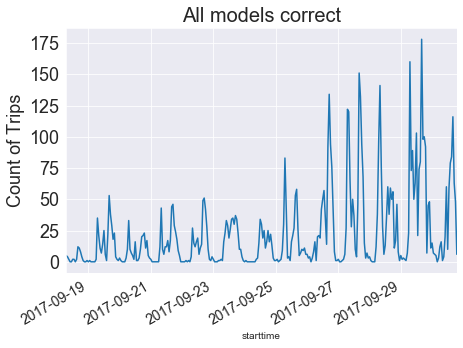

In [1133]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(7,5))
all_true.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'].plot(ax=ax)
plt.ylabel("Count of Trips", size=18)
plt.title("All models correct", size=20)
plt.xticks(size=14)
plt.yticks(size=18)
# plt.savefig("figures/all_models_correct_ts.png", bbox_inches='tight')

In [ ]:
all_true = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr == True)]
no_true = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr != True)]
only_svc = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr != True)]
only_rf = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr != True)]
only_nn = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr == True)]
all_but_svc = joined_mode_data.loc[(joined_mode_data.svc_corr != True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr == True)]
all_but_rf = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr != True)&(joined_mode_data.nn_corr == True)]
all_but_nn = joined_mode_data.loc[(joined_mode_data.svc_corr == True)&(joined_mode_data.rf_corr == True)&(joined_mode_data.nn_corr != True)]



array([ 1,  3,  3,  2,  8, 12,  1,  8,  4, 10,  9, 29])

In [1134]:
# only_rf.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'] / 
rf_grouped_hour = joined_mode_data.dropna(subset=['rf_pred']).set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip']
nn_grouped_hour = joined_mode_data.dropna(subset=['nn_pred']).set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip']
svm_grouped_hour = joined_mode_data.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip']



KeyError: ['rf_pred']

starttime
2017-09-18 07:00:00-04:00    0.000000
2017-09-18 08:00:00-04:00    0.000000
2017-09-18 09:00:00-04:00    0.000000
2017-09-18 10:00:00-04:00    0.000000
2017-09-18 11:00:00-04:00    0.000000
                               ...   
2017-09-30 15:00:00-04:00    0.077465
2017-09-30 16:00:00-04:00    0.098446
2017-09-30 17:00:00-04:00    0.201342
2017-09-30 18:00:00-04:00    0.010309
2017-09-30 19:00:00-04:00    0.045455
Name: id_trip, Length: 301, dtype: float64

starttime
2017-09-18 07:00:00-04:00    0.000000
2017-09-18 08:00:00-04:00    0.000000
2017-09-18 09:00:00-04:00    0.000000
2017-09-18 10:00:00-04:00    0.000000
2017-09-18 11:00:00-04:00    0.000000
                               ...   
2017-09-30 15:00:00-04:00    0.077465
2017-09-30 16:00:00-04:00    0.098446
2017-09-30 17:00:00-04:00    0.201342
2017-09-30 18:00:00-04:00    0.010309
2017-09-30 19:00:00-04:00    0.045455
Name: id_trip, Length: 301, dtype: float64

(-13.702889507952225, 1.2797721131962905e-25, 0, 300, {'1%': -3.4523371197407404, '5%': -2.871222860740741, '10%': -2.571929211111111}, -452.1306386643714)
(-19.103321712348702, 0.0, 0, 301, {'1%': -3.452263435801039, '5%': -2.871190526189069, '10%': -2.571911967527952}, -483.2101131559265)
failed


Text(0.5, 1.0, 'Incorrectly classified trips')

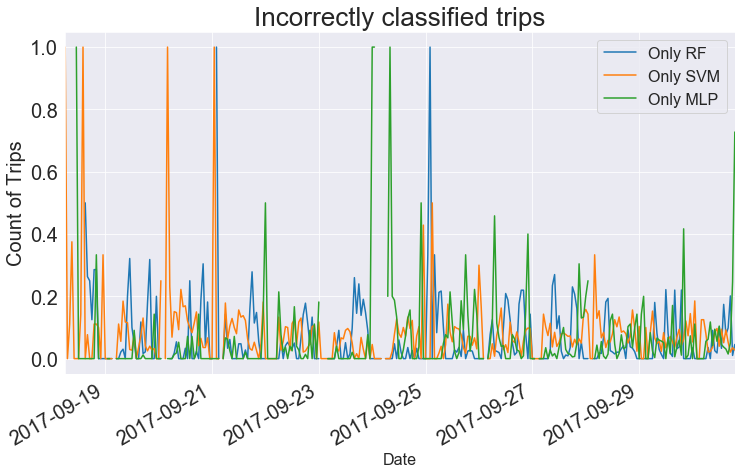

In [1143]:
fig, ax = plt.subplots(1, figsize=(12,7))
for df, df_name, grouped_hour in zip([all_but_rf, all_but_svc,all_but_nn],["RF Correct","SVM Correct","MLP Correct"], [rf_grouped_hour, svm_grouped_hour, nn_grouped_hour]):
    (df.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'] /grouped_hour).plot(ax=ax)
plt.legend(["Only RF","Only SVM","Only MLP"], fontsize=16)
plt.xlabel("Date", size=16)
plt.xticks(size=20)
plt.yticks(size=20)
# plt.ylim(0,1)
plt.ylabel("Count of Trips", size=20)
plt.title("Incorrectly classified trips", size=26)
# plt.savefig("figures/incorrect_classified_by_model.png", bbox_inches='tight')

In [1156]:
only_rf

,id_trip,mode,purpose,starttime,endtime,seconds,distance_m,direction,magnitude,carddir,...,nn5,nn6,nn7,nn8,geometry,which_correct,nn_pred,svc_corr,rf_corr,nn_corr
34,347109,walking,returning_home,2017-09-18 11:45:48-04:00,2017-09-18 12:10:22-04:00,609,176.945788,24.694761,0.499947,NNE,...,0.0,0.0,0.0,0.0,LINESTRING (7632290.105921159 1251215.68882495...,"(False, True, False)",NaN,False,True,False
39,119617,other,work,2017-09-18 12:57:40-04:00,2017-09-18 13:21:00-04:00,578,4694.960946,195.880438,0.188773,SSW,...,0.0,0.0,0.0,0.0,LINESTRING (7624015.797731058 1247372.35912239...,"(False, True, False)",NaN,False,True,False
46,175010,cycling,returning_home,2017-09-18 13:36:07-04:00,2017-09-18 13:41:12-04:00,286,1064.979172,260.987569,0.250322,W,...,0.0,0.0,0.0,0.0,LINESTRING (7631841.085444174 1247983.95282198...,"(False, True, False)",NaN,False,True,False
82,157624,car,returning_home,2017-09-18 17:11:11-04:00,2017-09-18 17:24:54-04:00,919,2262.784058,136.748003,0.011592,SE,...,0.0,0.0,0.0,0.0,LINESTRING (7638569.38728136 1249079.757209498...,"(False, True, False)",NaN,False,True,False
136,227822,car,returning_home,2017-09-18 22:24:48-04:00,2017-09-18 23:15:52-04:00,228,302.492971,185.562366,0.342475,S,...,0.0,0.0,0.0,0.0,LINESTRING (7638092.468455585 1250651.24077178...,"(False, True, False)",NaN,False,True,False
145,123174,cycling,work,2017-09-19 05:19:07-04:00,2017-09-19 05:24:22-04:00,1569,4436.602547,181.136381,0.230419,S,...,0.0,0.0,0.0,0.0,LINESTRING (7630273.339404611 1247304.59365778...,"(False, True, False)",NaN,False,True,False
148,286141,"walking, cycling",work,2017-09-19 05:34:00-04:00,2017-09-19 06:09:34-04:00,550,307.882594,189.106830,0.414064,S,...,0.0,0.0,0.0,0.0,LINESTRING (7632952.93424233 1244627.513538268...,"(False, True, False)",NaN,False,True,False
152,121508,car,work,2017-09-19 05:52:15-04:00,2017-09-19 06:38:53-04:00,1435,13711.701015,242.476306,0.076172,WSW,...,0.0,0.0,0.0,0.0,LINESTRING (7637731.148505384 1249463.17408337...,"(False, True, False)",NaN,False,True,False
157,119600,walking,work,2017-09-19 06:15:31-04:00,2017-09-19 06:25:31-04:00,486,478.426400,156.058703,0.270169,SSE,...,0.0,0.0,0.0,0.0,LINESTRING (7631639.111560544 1246155.29647739...,"(False, True, False)",NaN,False,True,False
160,276148,walking,work,2017-09-19 06:24:52-04:00,2017-09-19 06:57:41-04:00,398,270.183605,29.119855,0.399135,NNE,...,0.0,0.0,0.0,0.0,LINESTRING (7631823.871995728 1244934.58273344...,"(False, True, False)",NaN,False,True,False


In [1155]:
only_rf.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip']

starttime
2017-09-18 11:00:00-04:00     1
2017-09-18 12:00:00-04:00     1
2017-09-18 13:00:00-04:00     1
2017-09-18 14:00:00-04:00     0
2017-09-18 15:00:00-04:00     0
                             ..
2017-09-30 15:00:00-04:00    19
2017-09-30 16:00:00-04:00    17
2017-09-30 17:00:00-04:00    34
2017-09-30 18:00:00-04:00    27
2017-09-30 19:00:00-04:00     4
Name: id_trip, Length: 297, dtype: int64

Text(0.5, 1.0, 'Correctly classified trips')

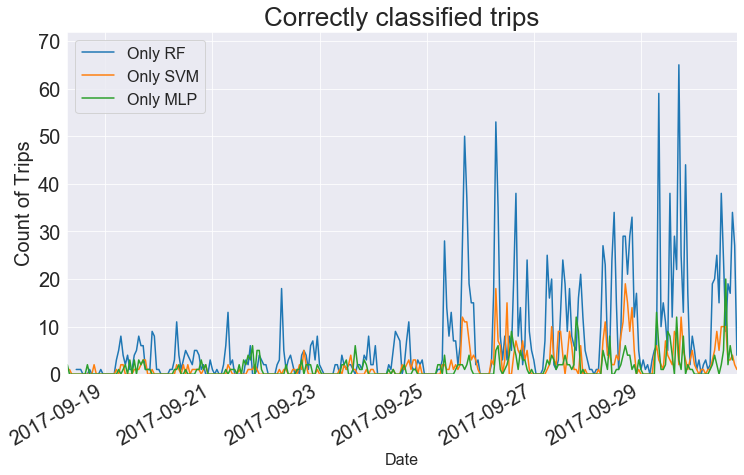

In [1151]:
fig, ax = plt.subplots(1, figsize=(12,7))
for df, df_name in zip([only_rf, only_svc,only_nn],["RF Correct","SVM Correct","MLP Correct"]):
    df.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'].plot(ax=ax)
plt.legend(["Only RF","Only SVM","Only MLP"], fontsize=16)
plt.xlabel("Date", size=16)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylim(0,72)
plt.ylabel("Count of Trips", size=20)
plt.title("Correctly classified trips", size=26)
# plt.savefig("figures/correct_classified_by_model.png", bbox_inches='tight')

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(7,5))
for i in [only_nn]
all_true.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'].plot(ax=ax)
plt.ylabel("Count of Trips", size=18)
plt.title("All models correct", size=20)
plt.xticks(size=14)
plt.yticks(size=18)
# plt.savefig("figures/all_models_correct_ts.png", bbox_inches='tight')

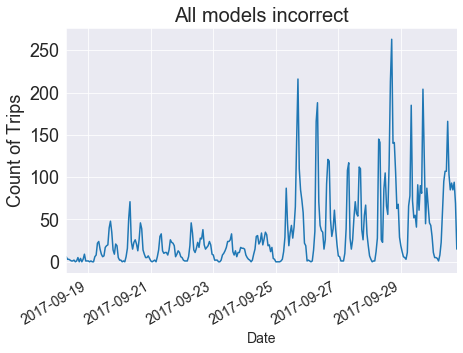

In [877]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, figsize=(7,5))
no_true.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip'].plot(ax=ax)
plt.ylabel("Count of Trips", size=18)
plt.title("All models incorrect", size=20)
plt.xticks(size=14)
plt.yticks(size=18)
plt.xlabel("Date", size=14)
plt.savefig("figures/all_models_incorrect_ts.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(14,4))
sns.heatmap(data_per_hour_t.T,ax=ax, linewidths=.1, annot=False, fmt='.0f', cbar_kws={'label': 'Count of Trips', "orientation": "vertical"});
ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(size=12)
plt.xlabel("Hour of Day", size=16)
plt.ylabel("Date", size=16)
# plt.title("", size=18)

Text(106.0, 0.5, 'Date')

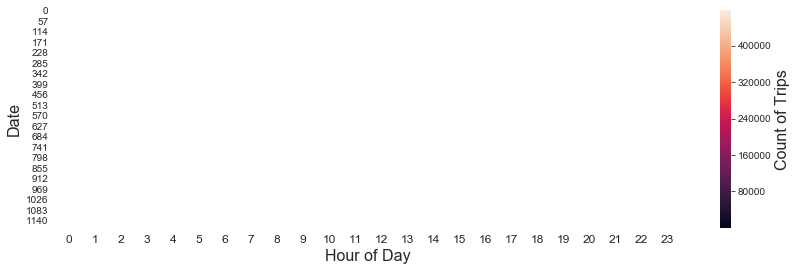

In [879]:
fig, ax = plt.subplots(1, figsize=(14,4))
sns.heatmap(data_per_hour_t.T,ax=ax, linewidths=.1, annot=False, fmt='.0f', cbar_kws={'label': 'Count of Trips', "orientation": "vertical"});
ax.set_xticklabels(labels=np.arange(0,24),rotation=0);
ax.figure.axes[-1].yaxis.label.set_size(16)
plt.xticks(size=12)
plt.xlabel("Hour of Day", size=16)
plt.ylabel("Date", size=16)
# plt.title("", size=18)
# plt.savefig("figures/grouped_hour_heatmap.png", bbox_inches='tight')

In [878]:
no_true.set_index('starttime').groupby(pd.Grouper(freq='1h')).count()['id_trip']

starttime
2017-09-18 07:00:00-04:00     6
2017-09-18 08:00:00-04:00     3
2017-09-18 09:00:00-04:00     3
2017-09-18 10:00:00-04:00     2
2017-09-18 11:00:00-04:00     1
                             ..
2017-09-30 15:00:00-04:00    93
2017-09-30 16:00:00-04:00    85
2017-09-30 17:00:00-04:00    94
2017-09-30 18:00:00-04:00    69
2017-09-30 19:00:00-04:00    15
Name: id_trip, Length: 301, dtype: int64

In [ ]:
data_per_hour_t.columns = [str(dt.date()) for dt in pd.date_range('2017-09-18', '2017-10-17', freq='D')]
